# Case Study: Handwritten Digit Classification

How good is your handwriting? If you write a number like "3", is it clearly distinct from an "8"? 

In the early days of machine learning, one of the most famous problems was *handwritten image recognition*. The goal was to teach algorithms to automatically recognize digits. This is very handy, for example, in post offices that need to sort thousands of pieces of mail every day on the basis of hand-written postal codes. 

More importantly, it is an example of the very general problem of teaching a computer to look at an image an 'understand' what it is looking at. Once the machine learning community achieved very good sucess on digit recognition, success on other images followed shortly.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

The most famous dataset of images is something called the MNIST dataset. However, in this video we will use a dataset of handwritten digits which sklearn supplies for us.

In [2]:
from sklearn.datasets import load_digits
digits=load_digits()

What type of object is digits?

In [3]:
type(digits)

sklearn.utils.Bunch

In [4]:
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

digits is a essentially a dictionary containing various information about our data. The data in this case is the predictor X. There are 64 columns in the data. Each column corresponds to a pixel in an 8x8 image.


In [5]:
digits['data'].shape
#1797 images, each image is a  64x1 vector, 8x8 grid, reshaped

(1797, 64)

Let's take a look

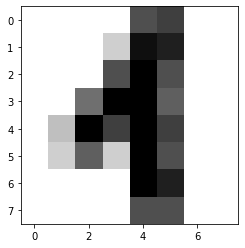

In [7]:
i=200
pic=digits['data'][i]
pic=pic.reshape(8,8)
fig,ax=plt.subplots(1)
ax.imshow(pic,cmap=plt.cm.binary)

The `target` in this case is an `array` of integers corresponding to the true digit. 

In [8]:
digits['target'].shape

(1797,)

This looks like complicated data, but as we'll see, we can achieve fairly strong predictive accuracy with tools that we've already learned. 

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(digits.data,digits.target)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

m=LogisticRegression(random_state=0,solver='liblinear')
cross_val_score(m,X_train,y_train,cv=10).mean()

0.9643338861249309

Ok, that looks fairly good! We suspect that we may be able to achieve accuracy of roughly 95% on the test data. Before we test this, let's try to understand where our model may be failing. This is an important part of the machine learning process -- when your model gives the wrong answer, you should **check why**. 

A good way to understand where a classification model is going wrong is via the *confusion matrix*. The confusion matrix is a simple visualization of the model's predictions against truth. To create a confusion matrix, we first need to explicitly extract the predictions. 

In [12]:
m.fit(X_train,y_train)
y_train_pred=m.predict(X_train)
y_train_pred

array([4, 6, 5, ..., 0, 7, 9])

In [13]:
from sklearn.metrics import confusion_matrix
c=confusion_matrix(y_train,y_train_pred)
c

array([[136,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 134,   0,   0,   0,   0,   0,   0,   2,   0],
       [  0,   0, 140,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 129,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 136,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 137,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 131,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 139,   0,   0],
       [  0,   3,   0,   1,   0,   0,   0,   0, 121,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2, 136]], dtype=int64)

The `i,j`th entry of this array gives the number of times that the model predicted digit `j` when the digit was in fact `i
`. Fortunately, we observe from the large numbers on the diagonal that the model is usually right, but not always! For example, there are cases in which the model predicts an 8 when the true digit was in fact a 1. Let's take a look at some of these cases. Boolean indexing gives us a convenient way to extract all of the incorrectly-classified digits: 

In [15]:
mask=y_train!=y_train_pred
mistakes=X_train[mask]
mistake_labels=y_train[mask]
mistake_preds=y_train_pred[mask]

mistake_preds, mistake_labels

(array([8, 8, 3, 8, 8, 1, 1, 1]), array([1, 9, 8, 1, 9, 8, 8, 8]))

Now, let's make one plot for each mistake

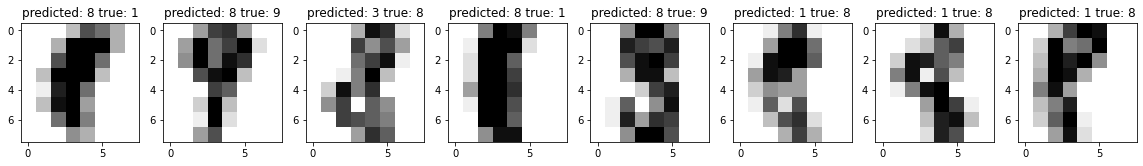

In [19]:
m_plots=len(mistakes)
fig,ax=plt.subplots(1,m_plots,figsize=(20,4))

for i in range(m_plots):
    ax[i].imshow(mistakes[i].reshape(8,8),cmap=plt.cm.binary)
    ax[i].set(title="predicted: "+str(mistake_preds[i])+ " true: "+ str(mistake_labels[i]))

Our model is understandably confused! Many of these digits would be difficult to correctly classify even for a human. On the other hand, one could do better...


For now, let's see how our model does on unseen data. Recall that we are expecting accuracy in the vicinity of 95%. 

In [20]:
m.score(X_test,y_test)

0.94

Well, that matches our expectations! We could also create a confusion matrix and visualize the errors on the test set, but that would be essentially all the same code, so we'll leave it as an exercise to the reader. 

## Can we do better? 

Yes! Modern handwritten digit classifiers use extremely complex neural networks to achieve over 99% accuracy, which is very impressive indeed. We don't need anything quite that fancy to significantly improve our own score.

A **multilayer perceptron** is perhaps the simplest form of neural network. It works by training layers of "neurons," which are very simple mathematical functions designed to adapt to nonlinearities in the data. Perceptrons with many layers of many neurons are able to flexibly fit a very wide variety of data; for this reason, however, they are also highly vulnerable to overfitting.  

In [21]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(solver = "lbfgs",
                   alpha = 1e-5, 
                   hidden_layer_sizes = (100, 100, 100, 100),
                   random_state = 0)

nn.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(100, 100, 100, 100),
              random_state=0, solver='lbfgs')

In [22]:
nn.score(X_test,y_test)

0.96

## ...can we do better?

Random forests are highly performant algorithms for regression and classification that work by training many different decision trees (which we've already seen) and treating them as a "committee" which then "votes" on the ultimate prediction. Until the advent of neural networks, random forests were one of the most widely performant algorithms in machine learning, and are still used in many applications. 


In [23]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators = 1000)
m.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [24]:
m.score(X_test,y_test)

0.9622222222222222

Using random forests, we were able to reduce our error rate to even less 

Note how easy and pleasant it is to work with the Scikit-learn interface -- we already knew how to use functions like `cross_val_score()`, `m.fit()`, and `m.score()`. All we needed to do was load up a different classifier model and instantiate it. 

# Bonus Material 

Another useful trick is to preprocess your image before feeding it into the classifier. There are many ways to do this, below is an example closely related to my research. For each image, we transform it using something called __The Scattering Transform__. The Scattering transfrom is a mathematical model of (portions of) a convolutional neural network, but for the purposes of this video, all you need to know is that it is it transforms each data point into a new data point. If we are lucky, the new data points will be easier to classify.

In order to run be able to run this code, open up anaconda prompt, type pip install kymatio and press enter. (This is optional.)


In [25]:
from kymatio.sklearn import Scattering2D

scattering_transformer = Scattering2D(2, (8, 8))

In [26]:
scattering_transformer(X_train.reshape(1347,8,8)).shape

(1347, 81, 2, 2)

In [27]:
transformed_data = scattering_transformer(X_train.reshape(1347,8,8))

In [28]:
m=LogisticRegression(random_state=0,solver='liblinear')

transformed_data=transformed_data.reshape(1347,81*2*2)

In [29]:

cross_val_score(m,transformed_data,y_train,cv=10).mean()


0.9747429519071309

In [30]:
cross_val_score(m,X_train,y_train,cv=10).mean()


0.9643338861249309